In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

file = "/content/gdrive/MyDrive/Wavy-Dataset1.xlsx"
DF = pd.read_excel(file, sheet_name='Sheet1')  # Data is of type 'Dataframe'
num_samples = DF.shape[0]
le = DF['le'].tolist()    # The strings are defined in the excel sheet
WF = DF['WF'].tolist()
AR = DF['AR'].tolist()
TR = DF['TR'].tolist()
Vf = DF['Vf'].tolist()
r1 = DF['r1'].tolist()
Rp = DF['Rp'].tolist()
Rvi = DF['Rvi'].tolist()
Rhi = DF['Rhi'].tolist()
CompAvgStr = DF['CompAvgStress'].tolist()
CompStrength = DF['CompStrength'].tolist()

In [ ]:
# Classification into good and bad designs based on the stress ratios
Good_Design = [[le[i], WF[i], AR[i], TR[i], Vf[i], r1[i], Rp[i], Rvi[i], Rhi[i], CompAvgStr[i], CompStrength[i]] for i in range(num_samples) if max(Rp[i], Rvi[i], Rhi[i])==Rvi[i]]
Bad_Design = [[le[i], WF[i], AR[i], TR[i], Vf[i], r1[i], Rp[i], Rvi[i], Rhi[i], CompAvgStr[i], CompStrength[i]] for i in range(num_samples) if max(Rp[i], Rvi[i], Rhi[i])!=Rvi[i]]

le_g, WF_g, AR_g, TR_g, Vf_g, r1_g, Rp_g, Rvi_g, Rhi_g, CompAvgStr_g, CompStrength_g = zip(*Good_Design)
le_b, WF_b, AR_b, TR_b, Vf_b, r1_b, Rp_b, Rvi_b, Rhi_b, CompAvgStr_b, CompStrength_b = zip(*Bad_Design)

In [ ]:
# Creating Dataframes for Good and Bad designs for Regression analysis
nd_var = {'le':le, 'WF':WF, 'AR':AR, 'TR':TR, 'Vf':Vf, 'r1':r1}  # No distinction
nd_out = {'Strength':CompStrength}

gd_var = {'le':le_g, 'WF':WF_g, 'AR':AR_g, 'TR':TR_g, 'Vf':Vf_g, 'r1':r1_g}    # Good Design
gd_out = {'Strength':CompStrength_g}

bd_var = {'le':le_b, 'WF':WF_b, 'AR':AR_b, 'TR':TR_b, 'Vf':Vf_b, 'r1':r1_b}    # Bad Design
bd_out = {'Strength':CompStrength_b}

ND_var_DF = pd.DataFrame(nd_var)
ND_out_DF = pd.DataFrame(nd_out)

GD_var_DF = pd.DataFrame(gd_var)
GD_out_DF = pd.DataFrame(gd_out)

BD_var_DF = pd.DataFrame(bd_var)
BD_out_DF = pd.DataFrame(bd_out)

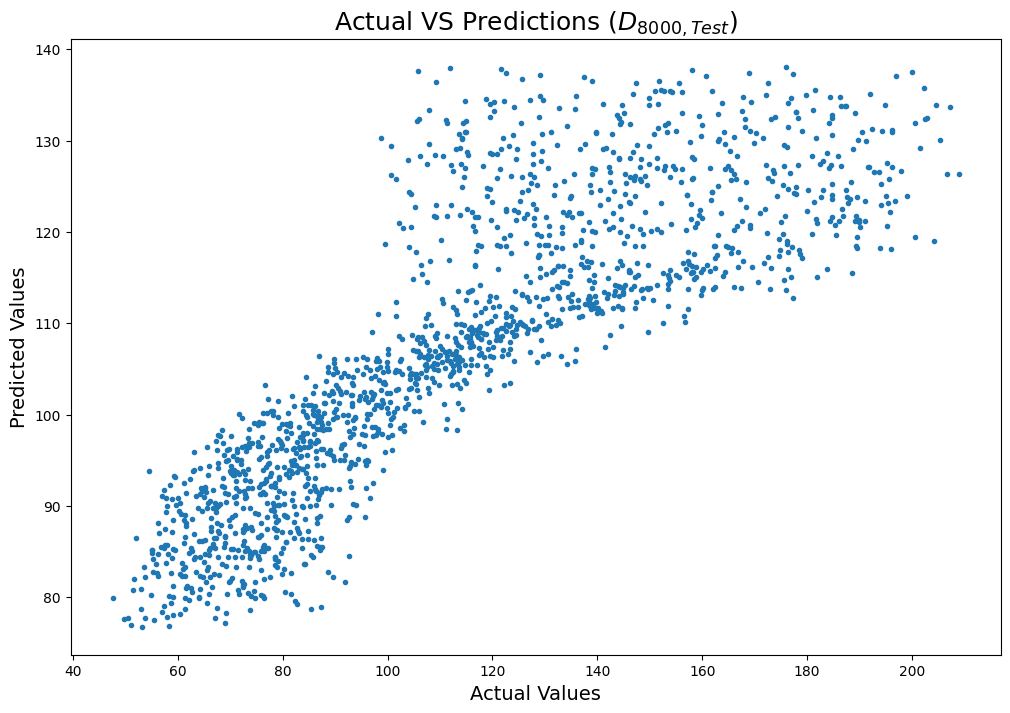

SVR score is:  0.5071763444353488 

The MSE and RMSE are:  (701.24, 26.48) 



In [ ]:
from sklearn.model_selection import train_test_split
X = ND_var_DF
y = ND_out_DF.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)    # 20% test size from total

from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = pd.DataFrame({'Predicted':y_pred, 'Actual':y_test})

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(x=y_test, y=y_pred, marker='.')
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual VS Predictions ($D_{8000, Test}$)', fontsize=18)
plt.show()

print('SVR score is: ', model.score(X_test, y_test), '\n')
import numpy as np
MSE_test = round(np.mean(np.square(y_pred-y_test)), 2)
RMSE_test = round(np.sqrt(MSE_test), 2)
print('The MSE and RMSE are: ', (MSE_test, RMSE_test), '\n')

In [ ]:
# Using GridSearch for tuning Hyperparameters
my_param_grid = {'C':[1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel':['rbf']}
from sklearn.model_selection import GridSearchCV
GridSearchCV(estimator=SVR(), param_grid=my_param_grid, refit=True, cv=5, n_jobs=-1)
grid = GridSearchCV(estimator=SVR(), param_grid=my_param_grid, refit=True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('Best parameters: ', grid.best_params_, '\n')
print('Best estimator: ', grid.best_estimator_, '\n')

Best parameters:  {'C': 1000, 'gamma': 1, 'kernel': 'rbf'} 

Best estimator:  SVR(C=1000, gamma=1) 



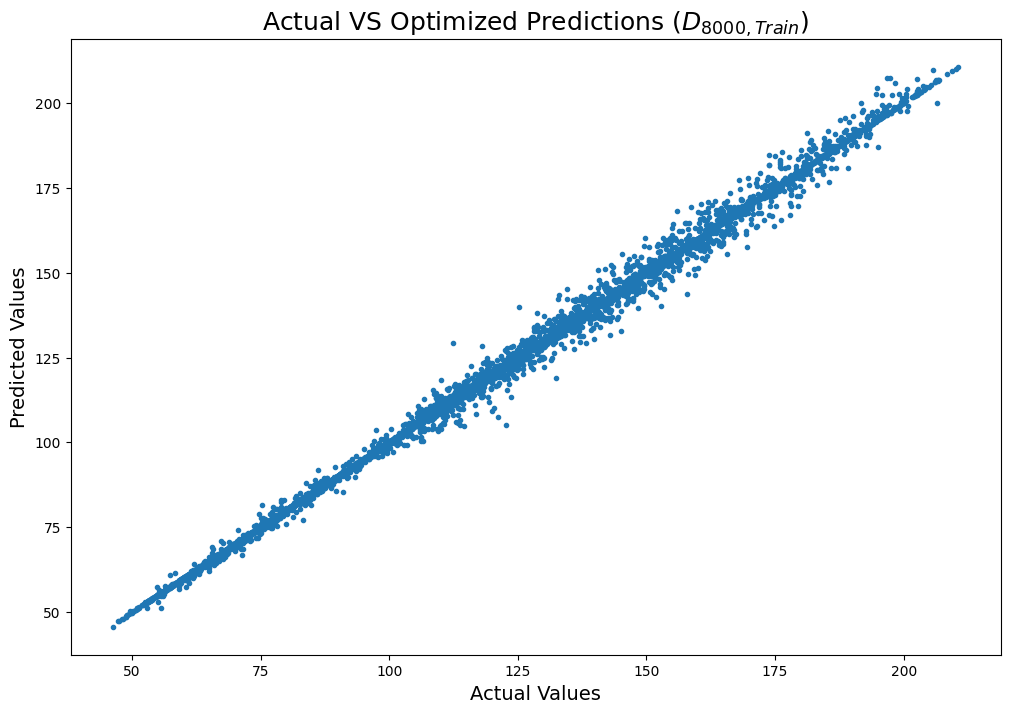

In [ ]:
y_pred_optimized = grid.predict(X_test)
predictions['Optimized'] = y_pred_optimized

y_pred_train_opt = grid.predict(X_train)
plt.figure(figsize=(12, 8))
plt.scatter(y_pred_train_opt, y_train, marker='.')
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual VS Optimized Predictions ($D_{8000, Train}$)', fontsize=18)
plt.show()

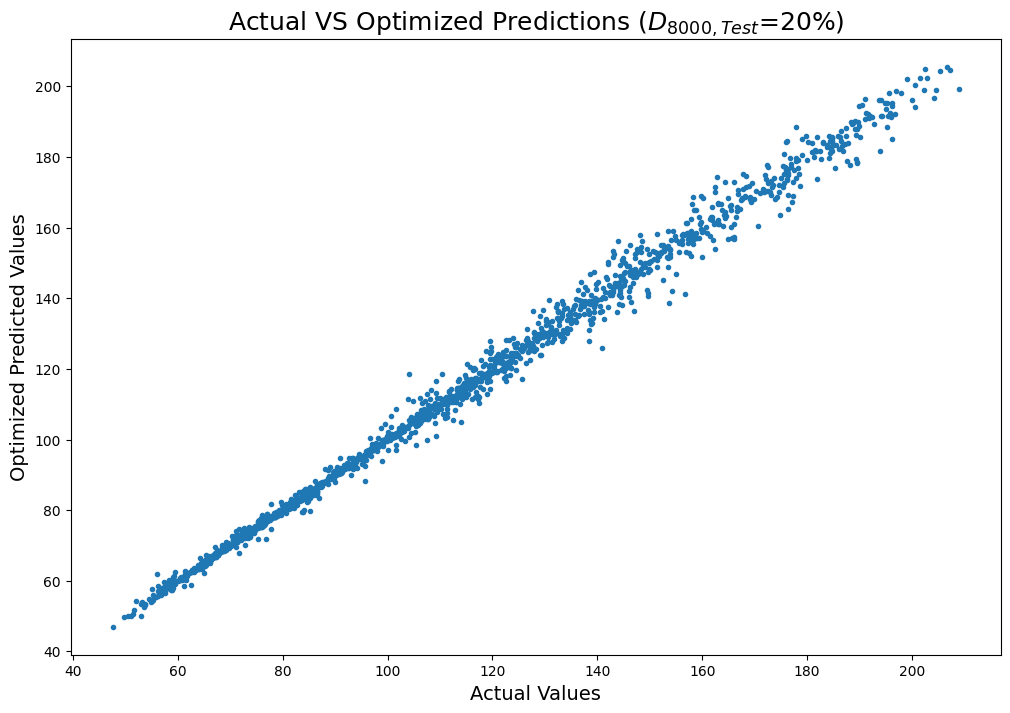

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_optimized, marker='.')
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Optimized Predicted Values', fontsize=14)
plt.title('Actual VS Optimized Predictions ($D_{8000, Test}$=20%)', fontsize=18)
plt.show()

In [ ]:
grid.score(X_test, y_test)
MSE_test_opt = round(np.mean(np.square(y_pred_optimized-y_test)), 2)
RMSE_test_opt = round(np.sqrt(MSE_test_opt), 2)
print('The SVR score after optimization is: ', grid.score(X_test, y_test), '\n')
print('The MSE and RMSE after optimization are: ', (MSE_test_opt, RMSE_test_opt), '\n')

The SVR score after optimization is:  0.9907980736004096 

The MSE and RMSE after optimization are:  (13.35, 3.65) 



In [ ]:
# Using CrossValidation for estimating performance metrics
from sklearn.model_selection import cross_val_score
NMSE = cross_val_score(estimator=SVR(C=grid.best_params_['C'], gamma=grid.best_params_['gamma']), X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')
MSE_CV = round(np.mean(-NMSE), 4)
RMSE_CV = round(np.sqrt(MSE_CV), 4)

In [ ]:
print(MSE_CV)
print(RMSE_CV)

9.4358
3.0718
